In [1]:
# Import Google Drive and mount
from google.colab import drive
drive.mount('/content/gdrive')

# Unzip dataset
!unzip "/content/gdrive/My Drive/Colab Notebooks/Deep Learning - MSc AI/Assignment 2/data1-2.h5.zip"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/Colab Notebooks/Deep Learning - MSc AI/Assignment 2/data1-2.h5.zip
replace data1.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Imports

In [0]:
import heapq
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
import warnings
import seaborn as sns

from prettytable import PrettyTable
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from tensorflow.python.keras.applications import (VGG16, VGG19, Xception,
                                                  InceptionV3, ResNet50)
from tensorflow.python.keras import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Average
from tensorflow.python.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# Ignore SciKit Learn warnings
warnings.filterwarnings('ignore')
# Ignore TensorFlow warnings
tf.logging.set_verbosity(tf.logging.ERROR)
# Reset TensorFlow default graph
tf.reset_default_graph()

# Build CNN

In [0]:
class ShallowCNN:

    @staticmethod
    def load_data_h5(path_to_file):
        """
        Load test and validation data from .h5 file.

        :param path_to_file: (str) The path to file
        :return: x_train: (ndarray) The training data feature set
        :return: y_train: (ndarray) The training data class labels
        :return: x_val: (ndarray) The validation data feature set
        :return: y_val: (ndarray) The validation data class labels
        :raises: exception (catch-all) When error found loading data
        """
        try:
            with h5py.File(path_to_file, 'r') as hf:
                x_train = np.array(hf.get('trainX'))
                y_train = np.array(hf.get('trainY'))
                x_val = np.array(hf.get('valX'))
                y_val = np.array(hf.get('valY'))
            return x_train, y_train, x_val, y_val
        except Exception as e:
            print("There was an issue extracting the data...")
            sys.exit(e)

    @staticmethod
    def plot_charts(history, epochs, chart_title):
        """
        Given a Keras history object, output the associated training and
        validation accuracy and loss results in a line chart.

        :param history: (keras-history-obj) The model history object
        :param epochs: (int) The amount of epochs used in training process
        :param chart_title: (string) The chart title
        """
        h = history
        e = epochs
        plt.style.use('ggplot')
        plt.figure()
        plt.plot(np.arange(0, e), h.history['loss'], label="train_loss")
        plt.plot(np.arange(0, e), h.history['val_loss'], label="val_loss")
        plt.plot(np.arange(0, e), h.history['acc'], label="train_acc")
        plt.plot(np.arange(0, e), h.history['val_acc'], label="val_acc")
        plt.title(chart_title)
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

    @staticmethod
    def get_pretrained_model(i_shape, vgg16=False, vgg19=False, xception=False,
                             inception=False, resnet50=False):
        """
        Retrieve a pre-trained CNN with the fully-connected layers removed. All
        weights are pre-trained on ImageNet. For more info see:
            https://keras.io/applications/

        :param i_shape: (tuple-int) The width, height, and depth of the inputs.
        :param vgg16: (bool) VGG16 model
        :param vgg19: (bool) VGG19 model
        :param xception: (booL) Xception V1 model
        :param inception: (bool) Inception V3 model
        :param resnet50: (bool) ResNet 50 model
        :return: (keras-model) The selected pre-trained model
        """

        if vgg16:
            return 'VGG16', VGG16(
                weights='imagenet', include_top=False, input_shape=i_shape)
        if vgg19:
            return 'VGG19', VGG19(
                weights='imagenet', include_top=False, input_shape=i_shape)
        if xception:
            return 'Xception', Xception(
                weights='imagenet', include_top=False, input_shape=i_shape)
        if inception:
            return 'InceptionV3', InceptionV3(
                weights='imagenet', include_top=False, input_shape=i_shape)
        if resnet50:
            return 'ResNet50', ResNet50(
                weights='imagenet', include_top=False, input_shape=i_shape)

        sys.exit("You must select a pre-trained model to use as a feature "
                 "extractor")

    @staticmethod
    def explore_pretrained_variants(
            i_shape, vgg16=False, vgg19=False, xception=False, inception=False,
            resnet50=False, ada_boost=False, gaussian_nb=False,
            knn=False, l_reg=False, mlp=False, quadratic_d=False, rfc=False,
            sgd=False, svc=False):
        """
        Explore various combinations of pre-trained models and classifiers.
        Output results in table format with final table of best results
        achieved through exploration. At least one pre-trained model and one
        classifier must be selected.

        :param i_shape: (tuple-int) The width, height, and depth of the inputs.
        :param vgg16: (bool) Include VGG16 model
        :param vgg19: (bool) Include VGG19 model
        :param xception: (booL) Include Xception V1 model
        :param inception: (bool) Include Inception V3 model
        :param resnet50: (bool) Include ResNet 50 model
        :param ada_boost:  (bool) Include AdaBoost classifier
        :param gaussian_nb: (bool) Include Gaussian Naive Bayes classifier
        :param knn: (bool) Include k-Nearest neighbors classifier
        :param l_reg: (bool) Include Logistic Regression classifier
        :param mlp: (bool) Include Multi-layer Perceptron classifier
        :param quadratic_d: (bool) Include Quadratic Discriminant Analysis
        classifier
        :param rfc: (bool) Include Random Forest Classifier
        :param sgd: (bool) Include Stochastic Gradient Descent classifier
        :param svc: (bool) Include C-Support Vector Classifier
        """
        # Instantiate lists to hold pre-trained models and classifiers
        pretrained_cnns = list()
        classifiers = list()

        # Select pre-trained models
        if vgg16:
            pretrained_cnns.append(['VGG16', VGG16(
                weights='imagenet', include_top=False, input_shape=i_shape)])
        if vgg19:
            pretrained_cnns.append(['VGG19', VGG19(
                weights='imagenet', include_top=False, input_shape=i_shape)])
        if xception:
            pretrained_cnns.append(['Xception', Xception(
                weights='imagenet', include_top=False, input_shape=i_shape)])
        if inception:
            pretrained_cnns.append(['InceptionV3', InceptionV3(
                weights='imagenet', include_top=False, input_shape=i_shape)])
        if resnet50:
            pretrained_cnns.append(['ResNet50', ResNet50(
                weights='imagenet', include_top=False, input_shape=i_shape)])
        # If no models are selected exit program
        if not pretrained_cnns:
            print("You must select at least one pre-trained model...")
            sys.exit()

        # Select classifiers
        if ada_boost:
            classifiers.append(AdaBoostClassifier())
        if gaussian_nb:
            classifiers.append(GaussianNB())
        if knn:
            classifiers.append(KNeighborsClassifier(3))
        if l_reg:
            classifiers.append(LogisticRegression())
        if mlp:
            classifiers.append(MLPClassifier(alpha=1, max_iter=1000))
        if quadratic_d:
            classifiers.append(QuadraticDiscriminantAnalysis())
        if rfc:
            classifiers.append(RandomForestClassifier(n_estimators=200))
        if sgd:
            classifiers.append(SGDClassifier())
        if svc:
            classifiers.append(SVC(kernel="linear", C=0.025))
        # If no classifiers are selected exit program
        if not pretrained_cnns:
            print("You must select at least one classifier...")
            sys.exit()

        # Instantiate heaps to hold individual model results and all results
        full_results_heap = []
        cnn_results_heap = []
        # For each of the selected models...
        for name, network in pretrained_cnns:
            # And for each of the selected classifiers...
            for classifier in classifiers:
                # Pass the training and validation data through the current
                # pre-trained model
                features_train, features_val = cnn.predict_reshape_data(
                    network, train_x, val_x)
                # Fit the feature data on the current classifier, calculate
                # accuracy of the classifier on validation data
                acc = cnn.fit_fdata_with_classifier(
                    classifier, features_train, train_y, features_val, val_y)
                # Add accuracy to both individual and full results heaps
                # Store accuracy as negative values to invert heap behaviour
                heapq.heappush(full_results_heap, (
                    -acc, name, classifier.__class__.__name__))
                heapq.heappush(cnn_results_heap, (
                    -acc, name, classifier.__class__.__name__))

            # Output the results of the current model ranked best to worst
            print("\n{} Transfer Learning w/ various ML algorithms".format(
                name))
            cnn_table = PrettyTable(['Rank', 'CNN', 'Classifier', 'Accuracy'])
            for i in range(0, len(cnn_results_heap)):
                result = heapq.heappop(cnn_results_heap)
                cnn_table.add_row(
                    [i + 1, result[1], result[2], abs(result[0])])
            print(cnn_table, '\n')

        # Output the top 10 (or less) results of the all models ranked best to
        # worst
        print("\nTop Results (All Pre-Trained Models & Classifiers)")
        full_table = PrettyTable(['Rank', 'CNN', 'Classifier', 'Accuracy'])
        result_cnt = 10 if len(full_results_heap) > 10 else len(
            full_results_heap)
        for i in range(0, result_cnt):
            result = heapq.heappop(full_results_heap)
            full_table.add_row([i + 1, result[1], result[2], abs(result[0])])
        print(full_table)

    @staticmethod
    def predict_reshape_data(keras_model, x_train, x_val):
        """
        Pass the training and validation image data through the pre-trained
        model and re-shape in preparation for fitting with classifier.

        :param keras_model: (keras-model) The pre-trained model
        :param x_train: (ndarray) The training data feature set
        :param x_val: (ndarray) The training data class labels
        :return: features_train (ndarray) The reshaped training data model
        output predictions
        :return: features_val (ndarray) The reshaped validation data model
        output predictions
        """
        # Get the model output predictions for the training data
        features_train = keras_model.predict(x_train)
        # Get the model output predictions for the validation data
        features_val = keras_model.predict(x_val)
        # Reshape the training data predictions
        features_train = features_train.reshape(features_train.shape[0], -1)
        # Reshape the validation data predictions
        features_val = features_val.reshape(features_val.shape[0], -1)

        return features_train, features_val

    @staticmethod
    def fit_fdata_with_classifier(classifier, features_train, y_train,
                                  features_val, y_val):
        """
        Using the classifier fit the feature training data and predict class
        for the validation data. From prediction results calculate classifier
        accuracy on validation data.

        :param classifier: (sk-classifier) The sklearn classifier
        :param features_train (ndarray) The reshaped training data model
        output predictions
        :param y_train: (ndarray) The training data class labels
        :param features_val (ndarray) The reshaped validation data model
        output predictions
        :param y_val: (ndarray) The validation data class labels
        :return: (float) The classifier accuracy
        """
        # Fit the feature training data on the classifier
        classifier.fit(features_train, y_train)
        # Predict class for validation data
        results = classifier.predict(features_val)
        # Calculate the classifier accuracy on the validation data
        acc = metrics.accuracy_score(results, y_val)

        return acc

    @staticmethod
    def augment_training_data(train_images, train_labels, batch_size,
                              width_shift=0., height_shift=0., shear=0.,
                              zoom=0., rotation=0, h_flip=False, v_flip=False):
        """
        Generate batches of tensor image data with real-time data augmentation.
        The data will be looped over (in batches).

        :param train_images: (ndarray) The training data feature set
        :param train_labels: (ndarray) The training data class labels
        :param batch_size: (int) The batch size, default 0 full data set
        :param width_shift: (float) Degree at which to shift image width
        :param height_shift: (float) Degree at which to shift image height
        :param shear: (float) Degree at which to shear image
        :param zoom: (float) Degree at which to zoom image
        :param rotation: (float) Degree range for random rotations
        :param h_flip: (bool) Randomly flip image horizontally
        :param v_flip: (bool) Randomly flip image vertically
        :return: (generator) The batches of augmented image data
        """
        # Define real-time data augmentation parameters
        train_data_generator = ImageDataGenerator(
            width_shift_range=width_shift, height_shift_range=height_shift,
            shear_range=shear, zoom_range=zoom, rotation_range=rotation,
            horizontal_flip=h_flip, vertical_flip=v_flip)

        # Take data & label arrays, generate batches of augmented data
        train_generator = train_data_generator.flow(train_images, train_labels,
                                                    batch_size)

        return train_generator

    def fine_tune_model(self, x_train, y_train, x_val, y_val, optimizer, loss,
                        pt_model, pt_name, tuning_layers, batch, epochs,
                        neuron_count, dropout, output_layer=None,
                        augmented_data=None):
        """
        Perform fine-tuning on a given pre-trained model.

        :param x_train: (ndarray) The training data feature set
        :param y_train: (ndarray) The training data class labels
        :param x_val: (ndarray) The validation data feature set
        :param y_val: (ndarray) The validation data class labels
        :param optimizer: (keras-optimizer) The model optimiser function
        :param loss: (str) The model loss function
        :param pt_model: (keras-model) The pre-trained model
        :param pt_name: (str) The model name
        :param tuning_layers: (list) The layers to fine-tune, these will have
        their trainable parameter set to True one by one in order after each
        pass of the data through the network
        :param batch: (int) The batch size
        :param epochs: (int) The amount of epochs used in training process
        :param neuron_count: (int|list) The amount of neurons to use in FC
        layer, if only one layer use single int, if more than one use list of
        ints
        :param dropout: (float|list) The dropout rate to use between FC layers,
        if only using one FC layer a single float value is required, if more
        than one FC layer, the dropout list must contain the same amount of
        values.
        :param output_layer: (str) The output layer uf using a portion of 
        pre-trained model
        :param augmented_data: (iterator) The augmented training data
        """
        # Set the model as NOT trainable for first pass of training data
        pt_model.trainable = False
        # Instantiate the table to output results at end
        tune_table = PrettyTable(['Phase', 'Loss', 'Accuracy'])
        # If an output layer has been specified...
        if output_layer:
            # Set the pre-trained model as the input, and output at the layer
            # specified in that model
            ft_model = Model(
                inputs=pt_model.input,
                outputs=pt_model.get_layer(output_layer).output)
        # Else the pre-trained model is used in its entirety
        else:
            ft_model = pt_model

        # Create the sequential keras model
        tf_model = Sequential()
        # Add the pre-trained model at the start
        tf_model.add(ft_model)
        # Flatten the network after the pre-trained model
        tf_model.add(Flatten())
        # If only one value for neuron count is given...
        if isinstance(neuron_count, int):
            # Add only one FC layer using the specified neuron count
            tf_model.add(Dense(neuron_count, activation='relu'))
            if dropout:
                tf_model.add(Dropout(dropout))
        # Else three FC layers are in use
        else:
            # Set the three neuron counts and dropout rates as specified in the
            # method inputs
            tf_model.add(Dense(neuron_count[0], activation='relu'))
            if dropout:
                tf_model.add(Dropout(dropout[0]))
            tf_model.add(Dense(neuron_count[1], activation='relu'))
            if dropout:
                tf_model.add(Dropout(dropout[1]))
            tf_model.add(Dense(neuron_count[2], activation='relu'))
            if dropout:
                tf_model.add(Dropout(dropout[2]))
        # Add the softmax classifier with value of classes set
        tf_model.add(Dense(17, activation='sigmoid'))

        # >>> PHASE A
        phase = 'A'
        # Configure the model for training
        tf_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        # If data augmentation is enabled...
        if augmented_data:
            # Train the model on data generated batch-by-batch by generator
            h = tf_model.fit_generator(
                train_gen, validation_data=(x_val, y_val),
                steps_per_epoch=(len(x_train) / 16), epochs=epochs)
        # Else data augmentation not enabled...
        else:
            # Train the model for a given number of epochs
            h = tf_model.fit(x_train, y_train, epochs=epochs,
                             batch_size=batch, validation_data=(x_val, y_val))
        # Plot the loss and accuracy results from phase A
        chart = "Phase {}".format(phase)
        self.plot_charts(h, epochs, chart)
        # Add the results to the table
        tune_table.add_row(
            [phase, h.history['val_loss'][-1], h.history['val_acc'][-1]])

        # >>> PHASE B & BEYOND
        # Set the model as trainable for second and all subsequent passes of
        # training data
        ft_model.trainable = True
        # Set incremental counter
        i = 0
        # For each convolutional layer specified in the layers to fine-tune
        for c_layer in tuning_layers:
            i += 1
            # Set trainable flag to False so all layers in network are set as
            # not trainable when iterated over until layer name matches the
            # given fine-tuning layer name
            trainable_flag = False
            for layer in ft_model.layers:
                if layer.name == c_layer:
                    trainable_flag = True
                layer.trainable = trainable_flag
            # Configure the model for training
            tf_model.compile(loss=loss, optimizer=optimizer,
                             metrics=['accuracy'])
            # If data augmentation is enabled...
            if augmented_data:
                # Train the model on data generated batch-by-batch by generator
                h = tf_model.fit_generator(
                    train_gen, validation_data=(x_val, y_val),
                    steps_per_epoch=(len(x_train) / 16), epochs=epochs)
            # Else data augmentation not enabled...
            else:
                h = tf_model.fit(x_train, y_train, epochs=epochs,
                                 batch_size=batch, validation_data=(x_val,
                                                                    y_val))
            # Plot the loss and accuracy results from current phase
            chart = "Phase {}".format(chr(ord(phase) + i))
            self.plot_charts(h, epochs, chart)
            # Add the results to the table
            tune_table.add_row([chr(ord(phase) + i), h.history['val_loss'][-1],
                                h.history['val_acc'][-1]])
        # Output the results of the current fine-tuning process
        print("Results of fine-tuning {}".format(pt_name))
        print(tune_table)

    @staticmethod
    def ensemble_predict(models, x_val, y_val, batch_size=16):
        """
        Predict accuracy of multiple models using ensemble technique.

        :param models: (list) List of two or more trained neural networks
        :param x_val: (ndarray) The validation data feature set
        :param y_val: (ndarray) The validation data class labels
        :param batch_size: (int) The batch size, default 16
        :return:
        """
        # Create list to hold each models predictions
        model_predictions = list()
        # For each model provided...
        for m in models:
            # Predict the accuracy of the model, this is performed in batches
            model_predictions.append(m.predict(x_val, batch_size=batch_size))

        # Take as input the list of tensors all of the same shape, and returns
        # a single tensor also of the same shape representing the average of
        # all input tensors
        pred_average = Average()(model_predictions)
        # Get the predicted target class as defined by the maximum value along
        # numpy array axis 1
        predictions = np.argmax(pred_average, axis=1)
        # Compare the predicted class with the validation labels to determine
        # amount of correct predictions, divide by the amount of validation
        # images to get the accuracy of the ensemble
        acc = np.sum(np.equal(predictions, y_val)) / y_val.shape[0]
        # Output confusion matrix
        cm = metrics.confusion_matrix(y_val, predictions)
        plt.figure(figsize=(9, 9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True,
                    cmap='Blues_r')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        all_sample_title = 'Accuracy Score: {0}'.format(acc)
        plt.title(all_sample_title, size=15)

        return acc

    def tweaked_fine_tune(self, x_train, y_train, x_val, y_val, epochs, plot):
        """
        This is a tweaked version of the fine-tuning process where phase A is
        skipped.  There is not as much variance available with this as it is
        a side experiment born out of a mistake that went well. Results have
        been seen as high as 95.88% from a single training process of 100
        epochs. Specifications:
            -Data augmented
            -VGG16 pre-trained model used with top removed
            -Model marked as trainable from fourth layer onwards from start
            -Decreasing rates of neuron count and dropout rate used
            -SGD optimiser used with 0.001 learning rate so weight change small
            -Sparse Categorical Cross Entropy loss function used

        :param x_train: (ndarray) The training data feature set
        :param y_train: (ndarray) The training data class labels
        :param x_val: (ndarray) The validation data feature set
        :param y_val: (ndarray) The validation data class labels
        :param epochs: (int) The number of epochs to run, default 10
        :param plot: (bool) If a chart is to be output
        :return: (keras-model) The trained model
        """
        trainable_flag = False
        loss = "sparse_categorical_crossentropy"
        t_gen = cnn.augment_training_data(
            x_train, y_train, 16, width_shift=0.1, height_shift=0.1, shear=0.1,
            zoom=0.1, rotation=10, v_flip=True, h_flip=True)

        __, pt_model = cnn.get_pretrained_model(input_shape, vgg16=True)
        pt_model.trainable = True

        for layer in pt_model.layers:
            if layer.name == 'block4_conv1':
                trainable_flag = True
            layer.trainable = trainable_flag

        tf_model = tf.keras.models.Sequential()
        tf_model.add(pt_model)
        tf_model.add(Flatten())
        tf_model.add(Dense(1024, activation='relu'))
        tf_model.add(Dropout(0.3))
        tf_model.add(Dense(512, activation='relu'))
        tf_model.add(Dropout(0.2))
        tf_model.add(Dense(256, activation='relu'))
        tf_model.add(Dropout(0.1))
        tf_model.add(Dense(17, activation='sigmoid'))

        tf_model.compile(loss=loss, optimizer=SGD(lr=0.001),
                         metrics=['accuracy'])
        h = tf_model.fit_generator(
            t_gen, validation_data=(x_val, y_val),
            steps_per_epoch=(len(x_train) / 16), epochs=epochs,
            shuffle=True, verbose=1)

        if plot:
            self.plot_charts(h, epochs, 'Altered Fine-Tune with VGG16')
        else:
            return tf_model

# Instantiate CCN and load data

In [4]:
# Declare Network Constants
NUM_EPOCHS = 30
BATCH_SIZE = 16

# Instantiate CNN class and load data
cnn = ShallowCNN()
print("Loading Data...")
train_x, train_y, val_x, val_y = cnn.load_data_h5('data1.h5')
input_shape = (128, 128, 3)

Loading Data...


# Part 1 - Transfer Learning

### Use a pre-trained CNN feeding into Logistic Regression algorithm

In [5]:
pretrained_model_name, pretrained_model = cnn.get_pretrained_model(
    input_shape, vgg16=True)

short_vgg16 = Model(inputs=pretrained_model.input,
                    outputs=pretrained_model.get_layer('block4_pool').output)

f_train, f_val = cnn.predict_reshape_data(short_vgg16, train_x, val_x)

ml_model = LogisticRegression()
accuracy = cnn.fit_fdata_with_classifier(LogisticRegression(),
                                         f_train, train_y, f_val, val_y)

print("{} CNN with {} Classifier Accuracy: {}".format(
    pretrained_model_name, ml_model.__class__.__name__, accuracy))

VGG16 CNN with LogisticRegression Classifier Accuracy: 0.8823529411764706


### Explore combinations of pre-trained CNNs and machine learning algorithms

In [6]:
cnn.explore_pretrained_variants(
    input_shape, vgg16=True, vgg19=True, xception=True, inception=True,
    resnet50=True, ada_boost=True, gaussian_nb=True, knn=True, l_reg=True,
    mlp=True, quadratic_d=True, rfc=True, sgd=True, svc=True)


VGG16 Transfer Learning w/ various ML algorithms
+------+-------+-------------------------------+---------------------+
| Rank |  CNN  |           Classifier          |       Accuracy      |
+------+-------+-------------------------------+---------------------+
|  1   | VGG16 |       LogisticRegression      |  0.8735294117647059 |
|  2   | VGG16 |         MLPClassifier         |  0.8705882352941177 |
|  3   | VGG16 |              SVC              |  0.8647058823529412 |
|  4   | VGG16 |     RandomForestClassifier    |  0.8176470588235294 |
|  5   | VGG16 |         SGDClassifier         |  0.6823529411764706 |
|  6   | VGG16 |      KNeighborsClassifier     |  0.6617647058823529 |
|  7   | VGG16 |           GaussianNB          |  0.4676470588235294 |
|  8   | VGG16 |       AdaBoostClassifier      | 0.22058823529411764 |
|  9   | VGG16 | QuadraticDiscriminantAnalysis | 0.14705882352941177 |
+------+-------+-------------------------------+---------------------+ 


VGG19 Transfer Learning 

# Part 2 - Fine Tuning

Set optimiser and loss functions, get pre-trained network for fine-tuning

In [0]:
# Create optimisers
adam_optimizer = Adam(lr=0.001)
sgd_optimizer = SGD(lr=0.001)
ada_optimizer = Adadelta()
# Set loss function
loss_function = "sparse_categorical_crossentropy"
# Load pre-trained CNN model VGG16
model_name, model = cnn.get_pretrained_model(input_shape, vgg16=True)
# Create generator for training data augmentation
train_gen = cnn.augment_training_data(
    train_x, train_y, BATCH_SIZE, width_shift=0.1, height_shift=0.1, shear=0.1,
    zoom=0.1, rotation=10, v_flip=True, h_flip=True)

### Test 1: Fine tune from 5th convolutional layer with only single new FC layer of relu neurons (AdaDelta Optimiser)

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 6s 6ms/sample - loss: 2.2799 - acc: 0.2755 - val_loss: 1.8668 - val_acc: 0.3735
Epoch 2/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 1.2180 - acc: 0.5971 - val_loss: 0.7764 - val_acc: 0.7824
Epoch 3/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.5756 - acc: 0.8118 - val_loss: 0.8464 - val_acc: 0.7176
Epoch 4/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.3077 - acc: 0.9039 - val_loss: 0.5831 - val_acc: 0.8235
Epoch 5/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.1563 - acc: 0.9510 - val_loss: 0.5832 - val_acc: 0.8206
Epoch 6/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.1085 - acc: 0.9765 - val_loss: 0.7959 - val_acc: 0.7676
Epoch 7/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0716 - acc: 0.9814 - val_loss: 0.5024 - val_acc: 0.8412
E

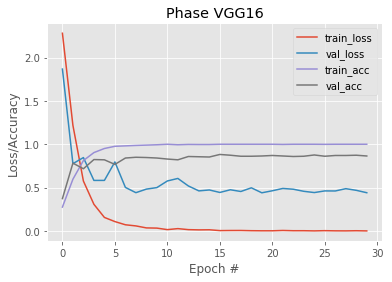

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 4s 3ms/sample - loss: 0.0040 - acc: 0.9980 - val_loss: 0.4807 - val_acc: 0.8647
Epoch 2/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 8.8868e-04 - acc: 1.0000 - val_loss: 0.4810 - val_acc: 0.8676
Epoch 3/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0016 - acc: 0.9990 - val_loss: 0.4445 - val_acc: 0.8676
Epoch 4/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 4.8612e-04 - acc: 1.0000 - val_loss: 0.4575 - val_acc: 0.8765
Epoch 5/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 5.0014e-04 - acc: 1.0000 - val_loss: 0.5931 - val_acc: 0.8382
Epoch 6/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 5.4289e-04 - acc: 1.0000 - val_loss: 0.4713 - val_acc: 0.8706
Epoch 7/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 6.2201e-04 - acc: 1.0000 - val_loss: 0.4749

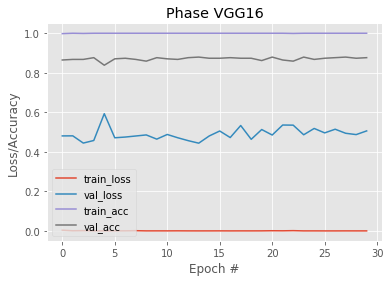

Results of fine-tuning VGG16
+-------+--------------------+------------+
| Phase |        Loss        |  Accuracy  |
+-------+--------------------+------------+
|   A   | 0.4411190388833775 | 0.86470586 |
|   B   | 0.5060270606430576 | 0.87647057 |
+-------+--------------------+------------+


In [8]:
tune_layers = ['block5_con1']
cnn.fine_tune_model(train_x, train_y, val_x, val_y, ada_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    NUM_EPOCHS, 256, 0.1)

### Test 2: Fine tune with new FC layer of relu neurons and make 5th layer trainable followed by 4th layer trainable (Adam Optimiser)

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 4s 3ms/sample - loss: 2.3349 - acc: 0.1422 - val_loss: 1.3039 - val_acc: 0.6500
Epoch 2/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.9918 - acc: 0.6902 - val_loss: 0.7534 - val_acc: 0.7824
Epoch 3/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.3778 - acc: 0.8941 - val_loss: 0.6273 - val_acc: 0.8235
Epoch 4/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.1406 - acc: 0.9627 - val_loss: 0.4656 - val_acc: 0.8559
Epoch 5/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0884 - acc: 0.9775 - val_loss: 0.5607 - val_acc: 0.8324
Epoch 6/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0571 - acc: 0.9892 - val_loss: 0.4066 - val_acc: 0.8794
Epoch 7/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0372 - acc: 0.9941 - val_loss: 0.4538 - val_acc: 0.8412
E

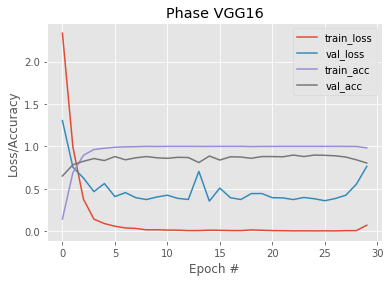

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.3130 - acc: 0.3020 - val_loss: 2.8264 - val_acc: 0.1147
Epoch 2/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7717 - acc: 0.0922 - val_loss: 2.8332 - val_acc: 0.0559
Epoch 3/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.8332 - acc: 0.0598 - val_loss: 2.8332 - val_acc: 0.0559
Epoch 4/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7878 - acc: 0.0843 - val_loss: 2.7199 - val_acc: 0.1000
Epoch 5/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7472 - acc: 0.1029 - val_loss: 2.7307 - val_acc: 0.1000
Epoch 6/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7272 - acc: 0.1010 - val_loss: 2.7508 - val_acc: 0.0853
Epoch 7/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7059 - acc: 0.1265 - val_loss: 2.7309 - val_acc: 0.1029
E

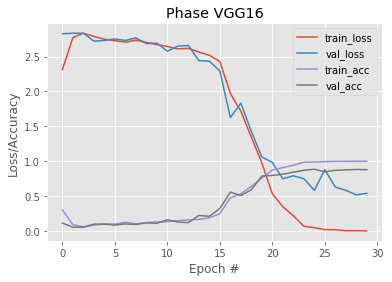

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 4s 4ms/sample - loss: 0.7516 - acc: 0.8510 - val_loss: 1.5261 - val_acc: 0.7382
Epoch 2/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.2891 - acc: 0.9324 - val_loss: 1.0011 - val_acc: 0.8353
Epoch 3/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0654 - acc: 0.9863 - val_loss: 0.6827 - val_acc: 0.8735
Epoch 4/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0135 - acc: 0.9980 - val_loss: 0.6988 - val_acc: 0.8706
Epoch 5/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0333 - acc: 0.9892 - val_loss: 0.7520 - val_acc: 0.8735
Epoch 6/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0319 - acc: 0.9912 - val_loss: 0.7712 - val_acc: 0.8412
Epoch 7/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0129 - acc: 0.9941 - val_loss: 0.6003 - val_acc: 0.8735
E

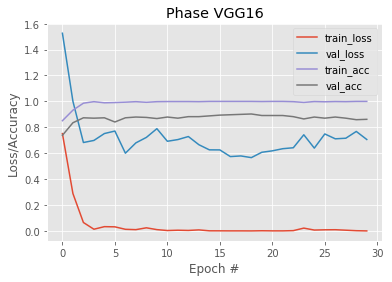

Results of fine-tuning VGG16
+-------+--------------------+------------+
| Phase |        Loss        |  Accuracy  |
+-------+--------------------+------------+
|   A   | 0.7632379929042038 | 0.8029412  |
|   B   | 0.540885574688368  | 0.87941176 |
|   C   | 0.7060780845144216 | 0.8617647  |
+-------+--------------------+------------+


In [9]:
tune_layers = ['block5_con1', 'block4_con1']
cnn.fine_tune_model(train_x, train_y, val_x, val_y, adam_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    NUM_EPOCHS, 256, 0.1)

### Test 3: Fine tune with new FC layer of relu neurons, remove 5th layer and make 4th layer trainable followed by 3rd layer (SGD Optimiser)

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 2.7691 - acc: 0.1255 - val_loss: 2.6175 - val_acc: 0.2353
Epoch 2/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 2.2107 - acc: 0.3059 - val_loss: 2.0344 - val_acc: 0.4559
Epoch 3/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 1.3531 - acc: 0.5549 - val_loss: 1.3616 - val_acc: 0.6235
Epoch 4/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.6358 - acc: 0.7912 - val_loss: 1.2780 - val_acc: 0.6706
Epoch 5/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.2700 - acc: 0.9324 - val_loss: 1.1129 - val_acc: 0.7059
Epoch 6/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.1243 - acc: 0.9725 - val_loss: 1.0509 - val_acc: 0.7382
Epoch 7/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0912 - acc: 0.9775 - val_loss: 0.9740 - val_acc: 0.7559
E

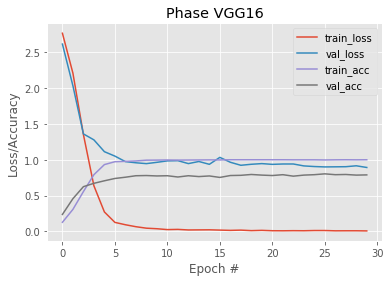

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0045 - acc: 0.9990 - val_loss: 0.8748 - val_acc: 0.7941
Epoch 2/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 0.8746 - val_acc: 0.8029
Epoch 3/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0059 - acc: 0.9990 - val_loss: 0.8854 - val_acc: 0.8029
Epoch 4/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0084 - acc: 0.9971 - val_loss: 0.9224 - val_acc: 0.7971
Epoch 5/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0073 - acc: 0.9980 - val_loss: 0.9032 - val_acc: 0.8059
Epoch 6/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0056 - acc: 0.9980 - val_loss: 0.8796 - val_acc: 0.8029
Epoch 7/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0072 - acc: 0.9980 - val_loss: 0.8801 - val_acc: 0.8059
E

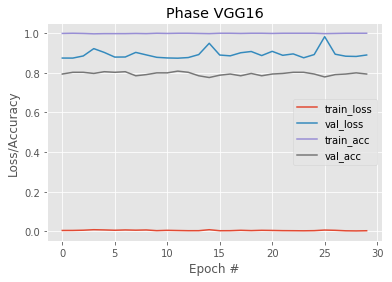

Train on 1020 samples, validate on 340 samples
Epoch 1/30
1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0026 - acc: 1.0000 - val_loss: 0.8938 - val_acc: 0.7971
Epoch 2/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0029 - acc: 1.0000 - val_loss: 0.8839 - val_acc: 0.8000
Epoch 3/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0047 - acc: 0.9980 - val_loss: 0.8898 - val_acc: 0.8000
Epoch 4/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0024 - acc: 1.0000 - val_loss: 0.8795 - val_acc: 0.8000
Epoch 5/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0026 - acc: 1.0000 - val_loss: 0.8615 - val_acc: 0.8088
Epoch 6/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0034 - acc: 1.0000 - val_loss: 0.8742 - val_acc: 0.8029
Epoch 7/30
1020/1020 [==============================] - 2s 2ms/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 0.8691 - val_acc: 0.8000
E

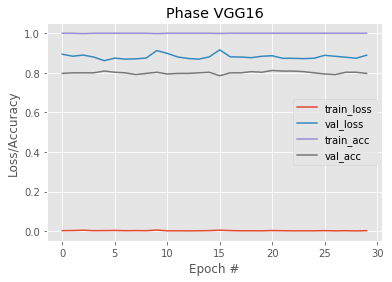

Results of fine-tuning VGG16
+-------+--------------------+-----------+
| Phase |        Loss        |  Accuracy |
+-------+--------------------+-----------+
|   A   | 0.8919720278066747 | 0.7882353 |
|   B   | 0.8901917627190843 | 0.7941176 |
|   C   | 0.8892096407273237 | 0.7970588 |
+-------+--------------------+-----------+


In [10]:
tune_layers = ['block4_con1', 'block3_con1']
out_layer = 'block4_pool'
cnn.fine_tune_model(train_x, train_y, val_x, val_y, sgd_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    NUM_EPOCHS, 256, 0.1, output_layer=out_layer)

### Test 4: Using augmented training data fine tune with new FC layer of relu neurons and make 5th layer trainable followed by 4th layer (AdaDelta Optimiser)

Epoch 1/30
64/64 [==============================] - 5s 78ms/step - loss: 2.4951 - acc: 0.1814 - val_loss: 1.9041 - val_acc: 0.2706
Epoch 2/30
64/64 [==============================] - 4s 64ms/step - loss: 1.5898 - acc: 0.4775 - val_loss: 0.9434 - val_acc: 0.7265
Epoch 3/30
64/64 [==============================] - 4s 65ms/step - loss: 1.1713 - acc: 0.6225 - val_loss: 0.7460 - val_acc: 0.7676
Epoch 4/30
64/64 [==============================] - 4s 65ms/step - loss: 0.8718 - acc: 0.7206 - val_loss: 0.6801 - val_acc: 0.7971
Epoch 5/30
64/64 [==============================] - 4s 65ms/step - loss: 0.7441 - acc: 0.7627 - val_loss: 0.7624 - val_acc: 0.7676
Epoch 6/30
64/64 [==============================] - 4s 65ms/step - loss: 0.6642 - acc: 0.7745 - val_loss: 0.6284 - val_acc: 0.8118
Epoch 7/30
64/64 [==============================] - 4s 65ms/step - loss: 0.5366 - acc: 0.8324 - val_loss: 0.5677 - val_acc: 0.8382
Epoch 8/30
64/64 [==============================] - 4s 65ms/step - loss: 0.4650 - a

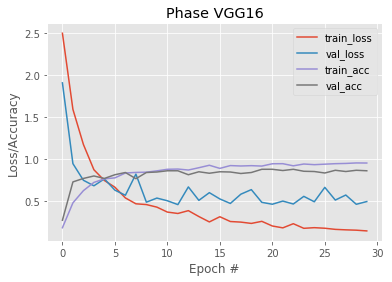

Epoch 1/30
64/64 [==============================] - 5s 77ms/step - loss: 0.2027 - acc: 0.9304 - val_loss: 0.5734 - val_acc: 0.8500
Epoch 2/30
64/64 [==============================] - 4s 64ms/step - loss: 0.1584 - acc: 0.9471 - val_loss: 0.4785 - val_acc: 0.8647
Epoch 3/30
64/64 [==============================] - 4s 65ms/step - loss: 0.1481 - acc: 0.9471 - val_loss: 0.4522 - val_acc: 0.8765
Epoch 4/30
64/64 [==============================] - 4s 65ms/step - loss: 0.1108 - acc: 0.9578 - val_loss: 0.4736 - val_acc: 0.8794
Epoch 5/30
64/64 [==============================] - 5s 72ms/step - loss: 0.1132 - acc: 0.9588 - val_loss: 0.4861 - val_acc: 0.8676
Epoch 6/30
64/64 [==============================] - 5s 74ms/step - loss: 0.1147 - acc: 0.9578 - val_loss: 0.5340 - val_acc: 0.8618
Epoch 7/30
64/64 [==============================] - 4s 68ms/step - loss: 0.1121 - acc: 0.9608 - val_loss: 0.6040 - val_acc: 0.8647
Epoch 8/30
64/64 [==============================] - 4s 65ms/step - loss: 0.1278 - a

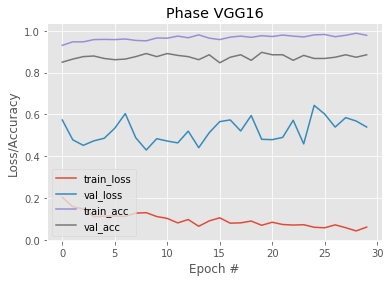

Epoch 1/30
64/64 [==============================] - 5s 78ms/step - loss: 0.0848 - acc: 0.9667 - val_loss: 0.5310 - val_acc: 0.8735
Epoch 2/30
64/64 [==============================] - 4s 64ms/step - loss: 0.0644 - acc: 0.9735 - val_loss: 0.5397 - val_acc: 0.8647
Epoch 3/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0525 - acc: 0.9794 - val_loss: 0.5711 - val_acc: 0.8735
Epoch 4/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0542 - acc: 0.9804 - val_loss: 0.5838 - val_acc: 0.8647
Epoch 5/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0420 - acc: 0.9882 - val_loss: 0.5161 - val_acc: 0.8794
Epoch 6/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0509 - acc: 0.9814 - val_loss: 0.5990 - val_acc: 0.8676
Epoch 7/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0407 - acc: 0.9863 - val_loss: 0.6146 - val_acc: 0.8735
Epoch 8/30
64/64 [==============================] - 4s 65ms/step - loss: 0.0501 - a

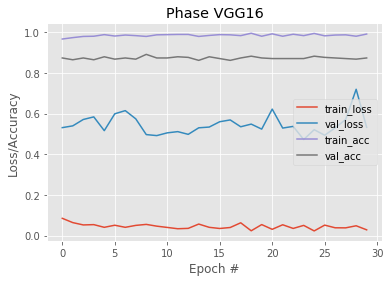

Results of fine-tuning VGG16
+-------+--------------------+------------+
| Phase |        Loss        |  Accuracy  |
+-------+--------------------+------------+
|   A   | 0.4929859700020064 | 0.85882354 |
|   B   | 0.5398013437674805 | 0.88529414 |
|   C   | 0.5325846709311008 | 0.87352943 |
+-------+--------------------+------------+


In [11]:
tune_layers = ['block5_con1', 'block4_con1']
cnn.fine_tune_model(train_x, train_y, val_x, val_y, ada_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    NUM_EPOCHS, 256, 0.1, augmented_data=train_gen)

### Test 5: Using augmented training data fine tune with three FC layer of ReLu neurons and make 5th layer trainable followed by 4th layer (AdaDelta Optimiser)

Epoch 1/50
64/64 [==============================] - 5s 83ms/step - loss: 2.6806 - acc: 0.1275 - val_loss: 2.9767 - val_acc: 0.0882
Epoch 2/50
64/64 [==============================] - 4s 67ms/step - loss: 2.1295 - acc: 0.2578 - val_loss: 1.6614 - val_acc: 0.4882
Epoch 3/50
64/64 [==============================] - 4s 67ms/step - loss: 1.6570 - acc: 0.4294 - val_loss: 1.4168 - val_acc: 0.4882
Epoch 4/50
64/64 [==============================] - 4s 67ms/step - loss: 1.3368 - acc: 0.5363 - val_loss: 0.8738 - val_acc: 0.6588
Epoch 5/50
64/64 [==============================] - 4s 67ms/step - loss: 1.1110 - acc: 0.6059 - val_loss: 1.0640 - val_acc: 0.6647
Epoch 6/50
64/64 [==============================] - 4s 67ms/step - loss: 0.8890 - acc: 0.6745 - val_loss: 0.7868 - val_acc: 0.7294
Epoch 7/50
64/64 [==============================] - 4s 67ms/step - loss: 0.8513 - acc: 0.6961 - val_loss: 0.6237 - val_acc: 0.8235
Epoch 8/50
64/64 [==============================] - 4s 67ms/step - loss: 0.7497 - a

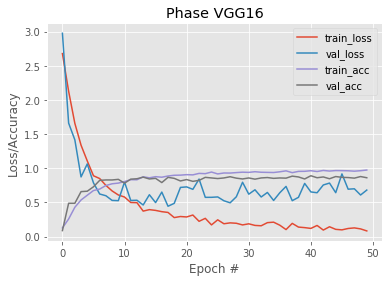

Epoch 1/50
64/64 [==============================] - 5s 83ms/step - loss: 0.1941 - acc: 0.9373 - val_loss: 0.6321 - val_acc: 0.8706
Epoch 2/50
64/64 [==============================] - 5s 71ms/step - loss: 0.1061 - acc: 0.9608 - val_loss: 0.5305 - val_acc: 0.8853
Epoch 3/50
64/64 [==============================] - 5s 76ms/step - loss: 0.0696 - acc: 0.9735 - val_loss: 0.7581 - val_acc: 0.8588
Epoch 4/50
64/64 [==============================] - 5s 72ms/step - loss: 0.0941 - acc: 0.9667 - val_loss: 0.8391 - val_acc: 0.8529
Epoch 5/50
64/64 [==============================] - 4s 67ms/step - loss: 0.0950 - acc: 0.9686 - val_loss: 0.6225 - val_acc: 0.8765
Epoch 6/50
64/64 [==============================] - 4s 67ms/step - loss: 0.0609 - acc: 0.9814 - val_loss: 0.7977 - val_acc: 0.8588
Epoch 7/50
64/64 [==============================] - 4s 67ms/step - loss: 0.1211 - acc: 0.9657 - val_loss: 0.6772 - val_acc: 0.8647
Epoch 8/50
64/64 [==============================] - 4s 68ms/step - loss: 0.1560 - a

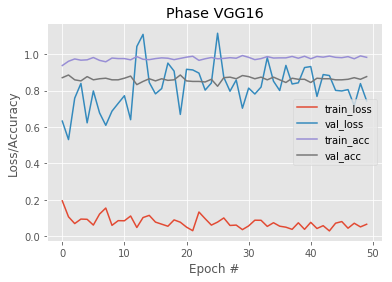

Epoch 1/50
64/64 [==============================] - 5s 83ms/step - loss: 0.0962 - acc: 0.9755 - val_loss: 1.0013 - val_acc: 0.8529
Epoch 2/50
64/64 [==============================] - 4s 67ms/step - loss: 0.0608 - acc: 0.9804 - val_loss: 0.9401 - val_acc: 0.8618
Epoch 3/50
64/64 [==============================] - 4s 68ms/step - loss: 0.0820 - acc: 0.9824 - val_loss: 0.7889 - val_acc: 0.8647
Epoch 4/50
64/64 [==============================] - 4s 67ms/step - loss: 0.0370 - acc: 0.9892 - val_loss: 0.8407 - val_acc: 0.8676
Epoch 5/50
64/64 [==============================] - 5s 73ms/step - loss: 0.0414 - acc: 0.9873 - val_loss: 0.9207 - val_acc: 0.8529
Epoch 6/50
64/64 [==============================] - 5s 77ms/step - loss: 0.0914 - acc: 0.9804 - val_loss: 0.9242 - val_acc: 0.8706
Epoch 7/50
64/64 [==============================] - 5s 72ms/step - loss: 0.0577 - acc: 0.9863 - val_loss: 0.8807 - val_acc: 0.8735
Epoch 8/50
64/64 [==============================] - 4s 67ms/step - loss: 0.0787 - a

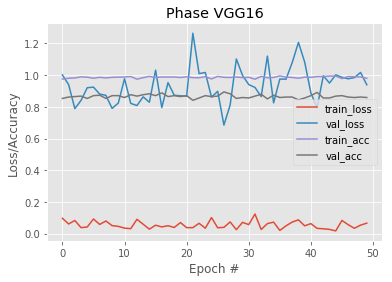

Results of fine-tuning VGG16
+-------+--------------------+------------+
| Phase |        Loss        |  Accuracy  |
+-------+--------------------+------------+
|   A   | 0.6813626288732683 | 0.8617647  |
|   B   | 0.7431634518910538 | 0.87647057 |
|   C   | 0.9393455040752253 | 0.85882354 |
+-------+--------------------+------------+


In [12]:
tune_layers = ['block5_con1', 'block4_con1']
cnn.fine_tune_model(train_x, train_y, val_x, val_y, ada_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    50, neuron_count=[1024, 512, 256], dropout=[0.1, 0.1, 0.1], 
                    augmented_data=train_gen)

### Test 6: Using augmented training data fine tune with three FC layer of relu neurons with dropout regularisation and make 5th layer trainable followed by 4th layer (SGD Classifier)


Epoch 1/30
64/64 [==============================] - 5s 81ms/step - loss: 2.7673 - acc: 0.1206 - val_loss: 2.6329 - val_acc: 0.2147
Epoch 2/30
64/64 [==============================] - 4s 65ms/step - loss: 2.5878 - acc: 0.1824 - val_loss: 2.3565 - val_acc: 0.2706
Epoch 3/30
64/64 [==============================] - 4s 65ms/step - loss: 2.3406 - acc: 0.2402 - val_loss: 2.0565 - val_acc: 0.3118
Epoch 4/30
64/64 [==============================] - 4s 65ms/step - loss: 2.1164 - acc: 0.2961 - val_loss: 1.8002 - val_acc: 0.4794
Epoch 5/30
64/64 [==============================] - 4s 65ms/step - loss: 1.8965 - acc: 0.3804 - val_loss: 1.5272 - val_acc: 0.4912
Epoch 6/30
64/64 [==============================] - 4s 65ms/step - loss: 1.7324 - acc: 0.4167 - val_loss: 1.5444 - val_acc: 0.4265
Epoch 7/30
64/64 [==============================] - 4s 65ms/step - loss: 1.5871 - acc: 0.4814 - val_loss: 1.2589 - val_acc: 0.6088
Epoch 8/30
64/64 [==============================] - 4s 67ms/step - loss: 1.4382 - a

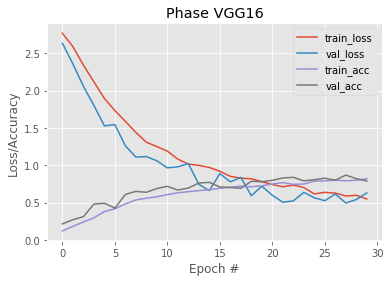

Epoch 1/30
64/64 [==============================] - 5s 80ms/step - loss: 0.5428 - acc: 0.8147 - val_loss: 0.5135 - val_acc: 0.8118
Epoch 2/30
64/64 [==============================] - 4s 64ms/step - loss: 0.5512 - acc: 0.8157 - val_loss: 0.5919 - val_acc: 0.8029
Epoch 3/30
64/64 [==============================] - 4s 65ms/step - loss: 0.5626 - acc: 0.8245 - val_loss: 0.5861 - val_acc: 0.8088
Epoch 4/30
64/64 [==============================] - 4s 65ms/step - loss: 0.4889 - acc: 0.8412 - val_loss: 0.5250 - val_acc: 0.8324
Epoch 5/30
64/64 [==============================] - 4s 65ms/step - loss: 0.4938 - acc: 0.8186 - val_loss: 0.6029 - val_acc: 0.8059
Epoch 6/30
64/64 [==============================] - 4s 65ms/step - loss: 0.5043 - acc: 0.8235 - val_loss: 0.4672 - val_acc: 0.8618
Epoch 7/30
64/64 [==============================] - 4s 65ms/step - loss: 0.4628 - acc: 0.8353 - val_loss: 0.5226 - val_acc: 0.8294
Epoch 8/30
64/64 [==============================] - 4s 65ms/step - loss: 0.4767 - a

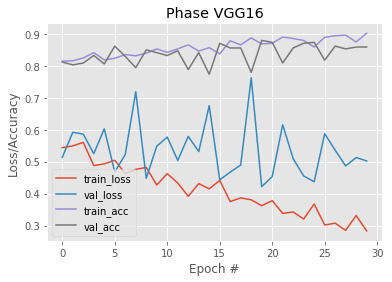

Epoch 1/30
64/64 [==============================] - 5s 84ms/step - loss: 0.3264 - acc: 0.8833 - val_loss: 0.5364 - val_acc: 0.8353
Epoch 2/30
64/64 [==============================] - 5s 72ms/step - loss: 0.3067 - acc: 0.9029 - val_loss: 0.5013 - val_acc: 0.8500
Epoch 3/30
64/64 [==============================] - 5s 73ms/step - loss: 0.2943 - acc: 0.8971 - val_loss: 0.5434 - val_acc: 0.8500
Epoch 4/30
64/64 [==============================] - 4s 66ms/step - loss: 0.2421 - acc: 0.9127 - val_loss: 0.5828 - val_acc: 0.8294
Epoch 5/30
64/64 [==============================] - 4s 65ms/step - loss: 0.2627 - acc: 0.9000 - val_loss: 0.4778 - val_acc: 0.8559
Epoch 6/30
64/64 [==============================] - 4s 65ms/step - loss: 0.2584 - acc: 0.9108 - val_loss: 0.5143 - val_acc: 0.8559
Epoch 7/30
64/64 [==============================] - 4s 65ms/step - loss: 0.2601 - acc: 0.9029 - val_loss: 0.4064 - val_acc: 0.8676
Epoch 8/30
64/64 [==============================] - 4s 65ms/step - loss: 0.3051 - a

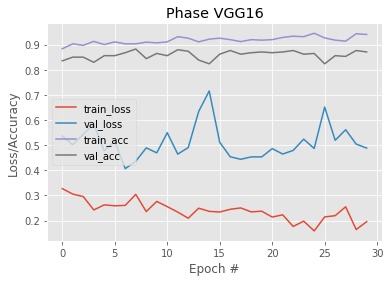

Results of fine-tuning VGG16
+-------+---------------------+------------+
| Phase |         Loss        |  Accuracy  |
+-------+---------------------+------------+
|   A   |  0.6289176981557499 | 0.7882353  |
|   B   |  0.5022582638670098 | 0.85882354 |
|   C   | 0.48813073121910466 | 0.87058824 |
+-------+---------------------+------------+


In [13]:
sgd_optimizer.lr = 0.01
tune_layers = ['block5_con1', 'block4_con1']
cnn.fine_tune_model(train_x, train_y, val_x, val_y, sgd_optimizer,
                    loss_function, model, model_name, tune_layers, BATCH_SIZE,
                    NUM_EPOCHS, neuron_count=[1024, 512, 256],
                    dropout=[0.1, 0.1, 0.1], augmented_data=train_gen)

### Test 7: Further fine-tuning experiments where 'phase A' is skipped and layers are made trainable in first pass
Fine tune with new three new FC layer of relu neurons, 5th layer trainable, and data augmented, dropout layer included and SGD learning rate reduced to 0.001

Epoch 1/60
64/64 [==============================] - 6s 100ms/step - loss: 2.8492 - acc: 0.0706 - val_loss: 2.7949 - val_acc: 0.0794
Epoch 2/60
64/64 [==============================] - 5s 74ms/step - loss: 2.8049 - acc: 0.0892 - val_loss: 2.7422 - val_acc: 0.1588
Epoch 3/60
64/64 [==============================] - 5s 76ms/step - loss: 2.7440 - acc: 0.1157 - val_loss: 2.6691 - val_acc: 0.2765
Epoch 4/60
64/64 [==============================] - 5s 74ms/step - loss: 2.6755 - acc: 0.1451 - val_loss: 2.5431 - val_acc: 0.3382
Epoch 5/60
64/64 [==============================] - 5s 76ms/step - loss: 2.5786 - acc: 0.1676 - val_loss: 2.3813 - val_acc: 0.3588
Epoch 6/60
64/64 [==============================] - 5s 84ms/step - loss: 2.4301 - acc: 0.2108 - val_loss: 2.1427 - val_acc: 0.3647
Epoch 7/60
64/64 [==============================] - 5s 79ms/step - loss: 2.2222 - acc: 0.2735 - val_loss: 1.9178 - val_acc: 0.4176
Epoch 8/60
64/64 [==============================] - 5s 74ms/step - loss: 2.0799 - 

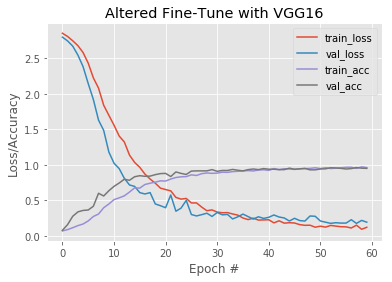

In [14]:
cnn.tweaked_fine_tune(train_x, train_y, val_x, val_y, 60, True)

### Test 8: Do the same as above with the tweaked fine-tuned network, this time run it through an ensemble network where all base-learners have same structure.

In [0]:
NUM_BASE_LEARNERS = 10
ens_models = list()
for base in range(0, NUM_BASE_LEARNERS):
    ens_models.append(cnn.tweaked_fine_tune(
        train_x, train_y, val_x, val_y, 60, False))

ens_val_acc = cnn.ensemble_predict(ens_models, val_x, val_y,
                                   batch_size=BATCH_SIZE)
print("Ensemble Validation Accuracy: {}".format(ens_val_acc))

Epoch 1/60
64/64 [==============================] - 6s 93ms/step - loss: 2.8553 - acc: 0.0569 - val_loss: 2.7909 - val_acc: 0.0941
Epoch 2/60
64/64 [==============================] - 5s 73ms/step - loss: 2.7930 - acc: 0.0941 - val_loss: 2.7383 - val_acc: 0.1794
Epoch 3/60
64/64 [==============================] - 5s 73ms/step - loss: 2.7565 - acc: 0.1118 - val_loss: 2.6682 - val_acc: 0.2382
Epoch 4/60
64/64 [==============================] - 5s 74ms/step - loss: 2.6991 - acc: 0.1441 - val_loss: 2.5637 - val_acc: 0.3353
Epoch 5/60
64/64 [==============================] - 5s 74ms/step - loss: 2.6111 - acc: 0.1735 - val_loss: 2.4284 - val_acc: 0.3735
Epoch 6/60
64/64 [==============================] - 5s 75ms/step - loss: 2.4917 - acc: 0.2069 - val_loss: 2.2527 - val_acc: 0.4294
Epoch 7/60
64/64 [==============================] - 5s 75ms/step - loss: 2.3279 - acc: 0.2882 - val_loss: 2.0096 - val_acc: 0.4559
Epoch 8/60
64/64 [==============================] - 5s 74ms/step - loss: 2.1838 - a